In [1]:
%pip -q install ffmpeg-python

Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.patches as patches

def draw_route(route, coords, ax, color="k"):
    edges = []
    for o, d in zip(route[:-1], route[1:]):
        o_x, o_y = coords[o]
        d_x, d_y = coords[d]
        edge = patches.FancyArrowPatch(
                (o_x, o_y),
                (d_x, d_y),
                edgecolor=color,
                arrowstyle='->',
                linewidth=1,
                mutation_scale=10,
                connectionstyle="arc", # angle = manhattan connection
                zorder=0)
        ax.add_artist(edge)
        edges.append(edge)
    return edges


def draw_points(coords, node_ids, ax):
    x,y = zip(*coords)
    x_depot, y_depot = x[0], y[0]
    x_customers, y_customers = x[1:],y[1:]
    ax.scatter(x_customers, y_customers, color="k", s=5, label="Customers")
    ax.scatter([x_depot], [y_depot], color="k", marker='s', s=20, label="Depot")
    draw_labels(node_ids, coords, ax)


def draw_vehicle_routes(routes, route_colors, coords, ax):
    for route, color in zip(routes, route_colors):
        draw_route([0] + list(route) + [0], coords, ax, color=color)


def draw_routes(solution, node_ids, coords, vehicle_route_colors, ax):

    rank, routes = solution
    # Erase previous graph
    ax.cla()
    
    # Set limit box
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    
    # Print total cost (sum of all route costs)
    ax.set_title(f"Rank: {rank+1:>3} - Cost: {get_total_cost(routes, coords):6.2f}")
    
    # Draw routes and points
    draw_vehicle_routes(routes, vehicle_route_colors, coords, ax)
    draw_points(coords, node_ids, ax)        
    
    ax.legend()


In [3]:
import numpy as np
np.random.seed(42)

def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((np.array(v1) - np.array(v2)) ** 2))   

def get_cost(route, coords):
    cost = 0
    for o,d in zip(route[1:], route[:-1]):
        cost+=euclidean_dist(coords[o], coords[d])
    return cost

def get_total_cost(routes, coords):
    total_cost = 0
    for route in routes:
        total_cost+=get_cost(route, coords)
    return total_cost

def draw_labels(node_labels, node_coords, ax):
    for n, label in enumerate(node_labels):
        ax.annotate(
            str(label),
            xy=node_coords[n],
            xytext=(-4, 6),
            textcoords="offset points")
        
def get_random_solution(n_customers, n_vehicles):
    routes = []
    customer_ids = np.arange(1,n_customers+1)
    for _ in range(n_vehicles-1):
        
        if len(customer_ids) == 1:
            break
        
        size = np.random.randint(low=1, high=len(customer_ids))
        route = list(np.random.choice(customer_ids, size=size, replace=False))
        routes.append(tuple(route))
        customer_ids = list(set(customer_ids).difference(route))
    
    if len(customer_ids) > 0:
        routes.append(tuple(customer_ids))
    return tuple(routes)

## Problem input

In [11]:
n_vehicles = 3
n_customers = 9

vehicle_route_colors = [
  '#e41a1c',
  '#377eb8',
  '#4daf4a',
  '#984ea3',
  '#ff7f00',
  '#ffff33']

# Random x and y coordinates for customers
x_customers = np.random.rand(n_customers)
y_customers = np.random.rand(n_customers)

# Depot at the center, assuming 0<= x, y <1
x_depot, y_depot = 0.5, 0.5

# List of coordinates with depot at the beginning
node_coords = [(x_depot, y_depot)] + list(zip(x_customers, y_customers))

# List of node ids (depot is 0)
node_ids = list(range(len(node_coords)))

## Create random solutions

To generate a random solution assuming `n_vehicles` vehicles and `n_customers` customers we:
- generate random routes for each vehicle,
- calculate the total cost (the sum of the euclidean distances of each vehicle route).

In [5]:
n_solutions = 100000
solutions = [
    get_random_solution(n_customers, n_vehicles)
    for _ in range(n_solutions)]

Total solutions: 100000 - Unique solutions: 91696


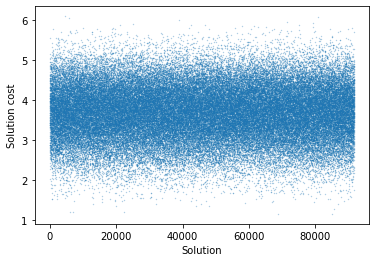

In [6]:
import matplotlib.pyplot as plt

unique_solutions = set(solutions)
print(
    f"Total solutions: {len(solutions)} "
    f"- Unique solutions: {len(unique_solutions)}")

sol_costs = [get_total_cost(s, node_coords) for s in unique_solutions]

plt.scatter(np.arange(len(sol_costs)), sol_costs, s=0.1, alpha=0.5)
plt.ylabel("Solution cost")
_ = plt.xlabel("Solution")

Show top 100 solutions

In [7]:
from pprint import pprint
sorted_sol = sorted(solutions, key=lambda s:get_total_cost(s, node_coords))
top_100 = list(enumerate(sorted_sol[:100]))
pprint(top_100[:10])

[(0, ((8, 2), (3, 4, 1, 9), (5, 6, 7))),
 (1, ((3, 4, 1, 9), (6, 5, 7), (2, 8))),
 (2, ((5, 6, 7), (8, 9, 1, 4, 3), (2,))),
 (3, ((3, 4, 9, 1), (8, 2), (5, 6, 7))),
 (4, ((7, 5, 6), (3, 4, 1), (2, 8, 9))),
 (5, ((6, 7, 5), (3, 4, 1, 9, 8), (2,))),
 (6, ((4, 3, 1, 9), (8, 2), (5, 6, 7))),
 (7, ((2, 8), (5, 6, 7), (1, 3, 4, 9))),
 (8, ((2, 8), (7, 6, 5), (1, 3, 4, 9))),
 (9, ((2, 8), (7, 6, 5), (1, 3, 4, 9)))]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
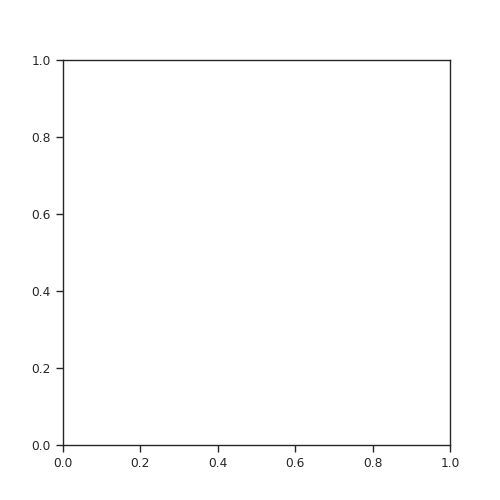

In [9]:
%matplotlib widget
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

fig, axis = plt.subplots(figsize=(5,5))

animator = animation.FuncAnimation(
    fig,
    draw_routes,
    top_100[::-1],
    fargs=(node_ids, node_coords, vehicle_route_colors, axis,),
    interval=100,
    repeat=False)

# If not closed, plot the first solution
# plt.close()
# HTML(animator.to_html5_video())